### 20180418: for bird_tw(73:1812), frog_tw(35:246), dog(15:66). (classNum:fileNum) 
### 20180419: modifying codes according to Richard's finding for enabling 4 mulit-GPU (search 'config for multi-GPU)

In [1]:
from scipy import io
import pandas as pd
import numpy as np
import time
import pickle
import os
import h5py
import sys, getopt
import datetime
from io_utils_mod import HDF5Matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
# from MapCallback import MapCallback

### config for multi-GPU ###
os.environ['CUDA_VISIBLE_DEVICES']='0,1,2,3'

In [2]:
hdf5path = '../data/all_data.hdf5' # training data generated by loadData.py
modelName2Save = 'trainModel_InceptionV3_1-v5_bird_frog_dog.h5'

In [3]:
modelPath = 'InceptionV3' #M: 沒用
logfileName = 'log.xls' #M: 沒用
#scalerFilePath = '../birdclef_data/standardScaler_5000.pickle'
scalerFilePath = None
preTrainedModelWeightsPath = None # path and filename to pretrained network: if there is a pretrained network, we can load it and continue to train it


tensorflowBackend = True # set true if Keras has TensorFlow backend - this way we set TF not to allocate all the GPU memory

if (tensorflowBackend):
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    from keras import backend as K
    K.set_session(sess)

print('hdf5path: %s, scalerFilePath: %s' % (hdf5path,scalerFilePath))

hdf5path: ../data/all_data.hdf5, scalerFilePath: None


Using TensorFlow backend.


In [4]:
scaler = None
scaleData = None
# if a scaler file generated by loadData.py is given, than load it and define a scaler function that will be used later
if scalerFilePath is not None:
    scaler = pickle.load(open(scalerFilePath, 'rb'))
    # Can't use scaler.transform because it only supports 2d arrays.
    def scaleData(X):
        return (X-scaler.mean_)/scaler.scale_

In [5]:
f = h5py.File(hdf5path, 'r')
X = f.get('X')
y = f.get('y')
print("Shape of X:", X.shape)
dataSetLength = X.shape[0]
output_dim = y.shape[1] #len(y_train[0])
f.close()
print('dataSetLength={}'.format(dataSetLength))
print('output_dim={}'.format(output_dim))

Shape of X: (18308, 1, 200, 310)
dataSetLength=18308
output_dim=123


In [6]:
X = np.array(HDF5Matrix(hdf5path, 'X', 0, dataSetLength, normalizer = scaleData))
y = np.array(HDF5Matrix(hdf5path, 'y', 0, dataSetLength))

#M: vvv 再多 shuffle 幾次...
X, y = shuffle(X, y, random_state=4)
X, y = shuffle(X, y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 4, test_size = 0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, random_state = 3, test_size = 0.1)

print('   X_train, y_train=', X_train.shape, y_train.shape, type(X_train), type(y_train))
print('   X_validation, y_validation=', X_validation.shape, y_validation.shape)
print('   X_test, y_test=', X_test.shape, y_test.shape)

   X_train, y_train= (14829, 1, 200, 310) (14829, 123) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
   X_validation, y_validation= (1648, 1, 200, 310) (1648, 123)
   X_test, y_test= (1831, 1, 200, 310) (1831, 123)


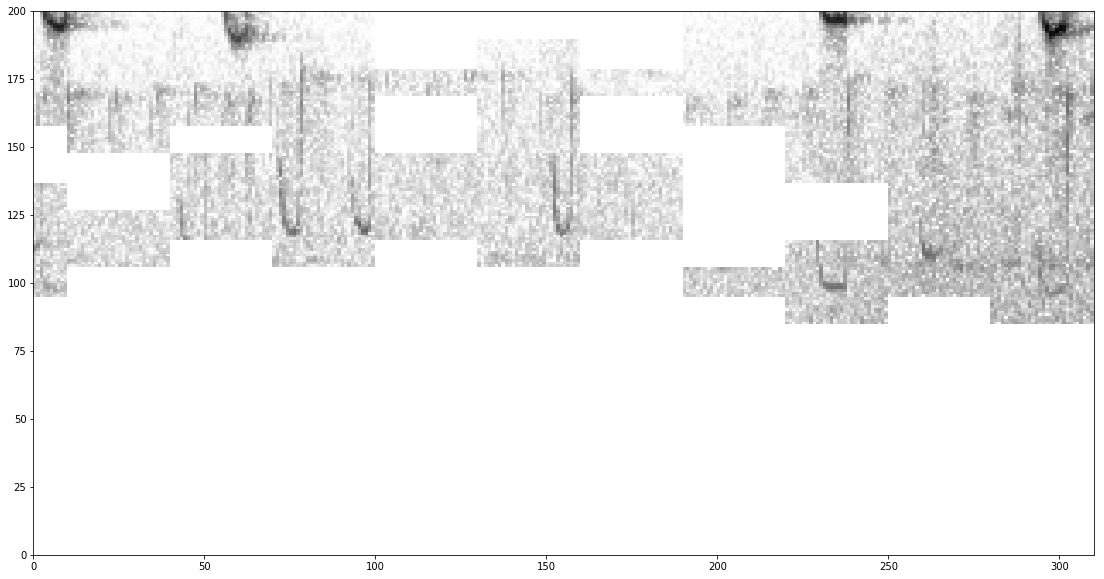

In [8]:
#M: 隨便抽張圖看看...
i=3
img = X_train[i].reshape((200,310))
fig = plt.figure(figsize=(19,10))
plt.tight_layout()
plt.pcolormesh(img, cmap=plt.cm.binary)
plt.show()

### vvvvv 將 AlexNet 換成 InceptionV3 Model vvvvv

In [9]:
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler
from keras.models import Model
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam, Nadam #M: 用 Adam, Nadam 沒用.
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import keras.backend as K
### config for multi-GPU ###
from keras.utils import multi_gpu_model

In [10]:
K.set_image_data_format('channels_first')
model = InceptionV3(include_top=False, weights=None, input_shape=(1,200,310), pooling='avg')

input_tensor = model.input
# build top
x = model.output
#M: 多加一層 128 dense layer
x = Dropout(.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(.5)(x)
x = Dense(output_dim, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=x)

### config for multi-GPU ###
# model.compile(optimizer=Nadam(), loss='categorical_crossentropy', metrics=['accuracy'])
parallel_model = multi_gpu_model(model, gpus=4)
parallel_model.compile(optimizer=Nadam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 200, 310)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 99, 154)  288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 99, 154)  96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 99, 154)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### ^^^^^ 將 AlexNet 換成 InceptionV3 Model ^^^^^

In [12]:
nb_epochs = 20000 # number of epochs, should be high, the end of the learning process is controled by early stoping
es_patience = 150 # patience for early stoping 
batchSize = 400 # batch size for mini-batch training

In [13]:
# lr decay schedule
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """

    lr = 1e-3
    decay = int(epoch / 100)
    if decay != 0:
        lr /= (10 ** decay)
    print('Learning rate = {}, decay = {}'.format(lr, decay))
    return lr

In [14]:
# call backs
if os.path.exists('./modelWeights/') is False:
    os.mkdir('./modelWeights/') #M:

### config for multi-GPU ###
checkpointer = ModelCheckpoint(filepath='./modelWeights/weights.{epoch:06d}-{val_loss:.2f}.hdf5', save_weights_only=True, verbose=1, save_best_only=True)
# checkpointer = ModelCheckpoint(filepath='./modelWeights/weights.h5', verbose=1, save_best_only=True)
lr = LearningRateScheduler(lr_schedule)

In [15]:
# load model and compile it, we use RMSprop here, other optimizer algorithm should be tested
# execfile(modelPath)
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop')#, metrics=["accuracy"])

# print the model
# print("The following model is used: ")
# for layer in model.layers:
#     print("{} output shape: {}".format(layer.name, layer.output_shape))

# load pretrained model if it is set
# if preTrainedModelWeightsPath is not None:
#     model.load_weights(preTrainedModelWeightsPath)
#     print("Reloaded weights from: {}".format(preTrainedModelWeightsPath))

# define callback functions
# mapcallback = MapCallback()

earlyStopping = EarlyStopping(monitor='val_loss', patience = es_patience) # early stoping

# save best models based on accuracy, loss and MAP metrics
#bestModelFilePath_val_map = './modelWeights/best_val_map_{}_{}.hdf5'.format(output_dim, datetime.datetime.now().strftime('%Y-%m-%d-%M-%S'))
#bestModelFilePath_val_acc = './modelWeights/best_val_acc_{}_{}.hdf5'.format(output_dim, datetime.datetime.now().strftime('%Y-%m-%d-%M-%S'))
#bestModelFilePath_val_loss = './modelWeights/best_val_loss_{}_{}.hdf5'.format(output_dim, datetime.datetime.now().strftime('%Y-%m-%d-%M-%S'))


# bestModelFilePath_val_acc = './modelWeights/best_val_acc_{}.hdf5'.format(output_dim)
# bestModelFilePath_val_loss = './modelWeights/best_val_loss_{}.hdf5'.format(output_dim)
# bestModelFilePath_val_map = './modelWeights/best_val_map_{}.hdf5'.format(output_dim)
# checkpointer_val_acc = ModelCheckpoint(filepath = bestModelFilePath_val_acc, verbose = 1, monitor = 'val_acc', save_best_only = True)
# checkpointer_val_loss = ModelCheckpoint(filepath = bestModelFilePath_val_loss, verbose = 1, monitor = 'val_loss', save_best_only = True)
# checkpointer_val_map = ModelCheckpoint(filepath = bestModelFilePath_val_map, verbose = 1, monitor = 'val_map', mode = 'max', save_best_only = True)

In [16]:
# store the starting time 
startTime = time.time()

### config for multi-GPU ###
fitting_result = parallel_model.fit(X_train, y_train, epochs = nb_epochs, batch_size = batchSize, shuffle = True, callbacks = [earlyStopping, checkpointer, lr], validation_data = (X_validation, y_validation))
# fitting_result = model.fit(X_train, y_train, epochs = nb_epochs, batch_size = batchSize, shuffle = True, callbacks = [earlyStopping, checkpointer, lr], validation_data = (X_validation, y_validation))

# calculate the elapsed time
elapsed = time.time()-startTime;
print("Execution time: {0} s".format(elapsed))

# save model
model.save(modelName2Save)

Train on 14829 samples, validate on 1648 samples
Learning rate = 0.001, decay = 0
Epoch 1/20000
14800/14829 [============================>.] - ETA: 0s - loss: 4.3790 - acc: 0.1144
Epoch 00001: val_loss improved from inf to 15.75843, saving model to ./modelWeights/weights.000001-15.76.hdf5
14829/14829 [==============================] - 47s 3ms/step - loss: 4.3791 - acc: 0.1143 - val_loss: 15.7584 - val_acc: 0.0133
Learning rate = 0.001, decay = 0
Epoch 2/20000
14800/14829 [============================>.] - ETA: 0s - loss: 3.9049 - acc: 0.1607
Epoch 00002: val_loss improved from 15.75843 to 5.89332, saving model to ./modelWeights/weights.000002-5.89.hdf5
14829/14829 [==============================] - 30s 2ms/step - loss: 3.9049 - acc: 0.1608 - val_loss: 5.8933 - val_acc: 0.0394
Learning rate = 0.001, decay = 0
Epoch 3/20000
14800/14829 [============================>.] - ETA: 0s - loss: 3.6166 - acc: 0.2017
Epoch 00003: val_loss improved from 5.89332 to 5.85381, saving model to ./modelWei

14800/14829 [============================>.] - ETA: 0s - loss: 1.0018 - acc: 0.7411
Epoch 00027: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 1.0033 - acc: 0.7408 - val_loss: 5.7810 - val_acc: 0.1717
Learning rate = 0.001, decay = 0
Epoch 28/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.8976 - acc: 0.7668
Epoch 00028: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 0.8978 - acc: 0.7667 - val_loss: 7.3951 - val_acc: 0.2846
Learning rate = 0.001, decay = 0
Epoch 29/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.6958 - acc: 0.8155
Epoch 00029: val_loss did not improve
14829/14829 [==============================] - 27s 2ms/step - loss: 0.6984 - acc: 0.8150 - val_loss: 6.8093 - val_acc: 0.1110
Learning rate = 0.001, decay = 0
Epoch 30/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.8018 - acc: 0.7913
Epoch 00030: val_loss did no

Learning rate = 0.001, decay = 0
Epoch 54/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.4759 - acc: 0.8811
Epoch 00054: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 0.4770 - acc: 0.8806 - val_loss: 4.1273 - val_acc: 0.4326
Learning rate = 0.001, decay = 0
Epoch 55/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.2836 - acc: 0.9239
Epoch 00055: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 0.2864 - acc: 0.9235 - val_loss: 3.8607 - val_acc: 0.4873
Learning rate = 0.001, decay = 0
Epoch 56/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.2987 - acc: 0.9211
Epoch 00056: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 0.3003 - acc: 0.9207 - val_loss: 3.1459 - val_acc: 0.5024
Learning rate = 0.001, decay = 0
Epoch 57/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0

Learning rate = 0.001, decay = 0
Epoch 81/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.1544 - acc: 0.9591
Epoch 00081: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 0.1559 - acc: 0.9587 - val_loss: 2.6607 - val_acc: 0.5959
Learning rate = 0.001, decay = 0
Epoch 82/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.1316 - acc: 0.9643
Epoch 00082: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 0.1344 - acc: 0.9638 - val_loss: 4.8814 - val_acc: 0.3792
Learning rate = 0.001, decay = 0
Epoch 83/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.2297 - acc: 0.9434
Epoch 00083: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 0.2307 - acc: 0.9430 - val_loss: 3.2594 - val_acc: 0.5552
Learning rate = 0.001, decay = 0
Epoch 84/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0

Learning rate = 0.0001, decay = 1
Epoch 107/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.0327 - acc: 0.9916
Epoch 00107: val_loss improved from 0.66344 to 0.65909, saving model to ./modelWeights/weights.000107-0.66.hdf5
14829/14829 [==============================] - 29s 2ms/step - loss: 0.0333 - acc: 0.9914 - val_loss: 0.6591 - val_acc: 0.8805
Learning rate = 0.0001, decay = 1
Epoch 108/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.0299 - acc: 0.9924
Epoch 00108: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 0.0331 - acc: 0.9916 - val_loss: 0.6701 - val_acc: 0.8774
Learning rate = 0.0001, decay = 1
Epoch 109/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.0318 - acc: 0.9924
Epoch 00109: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 0.0336 - acc: 0.9920 - val_loss: 0.6896 - val_acc: 0.8756
Learning rate = 0.0001, decay = 

14800/14829 [============================>.] - ETA: 0s - loss: 0.0180 - acc: 0.9955
Epoch 00134: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 0.0185 - acc: 0.9954 - val_loss: 0.6835 - val_acc: 0.8853
Learning rate = 0.0001, decay = 1
Epoch 135/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.0171 - acc: 0.9956
Epoch 00135: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 0.0177 - acc: 0.9955 - val_loss: 0.6843 - val_acc: 0.8865
Learning rate = 0.0001, decay = 1
Epoch 136/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.0153 - acc: 0.9956
Epoch 00136: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 0.0166 - acc: 0.9953 - val_loss: 0.7109 - val_acc: 0.8829
Learning rate = 0.0001, decay = 1
Epoch 137/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.0191 - acc: 0.9947
Epoch 00137: val_loss 

Learning rate = 0.0001, decay = 1
Epoch 162/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.0185 - acc: 0.9951
Epoch 00162: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 0.0193 - acc: 0.9949 - val_loss: 0.7477 - val_acc: 0.8829
Learning rate = 0.0001, decay = 1
Epoch 163/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.0163 - acc: 0.9955
Epoch 00163: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 0.0183 - acc: 0.9951 - val_loss: 0.7066 - val_acc: 0.8841
Learning rate = 0.0001, decay = 1
Epoch 164/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.0167 - acc: 0.9953
Epoch 00164: val_loss did not improve
14829/14829 [==============================] - 27s 2ms/step - loss: 0.0184 - acc: 0.9948 - val_loss: 0.7394 - val_acc: 0.8774
Learning rate = 0.0001, decay = 1
Epoch 165/20000
14800/14829 [============================>.] - ETA: 0s -

Learning rate = 0.0001, decay = 1
Epoch 190/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.0130 - acc: 0.9965
Epoch 00190: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 0.0145 - acc: 0.9962 - val_loss: 0.7585 - val_acc: 0.8750
Learning rate = 0.0001, decay = 1
Epoch 191/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.0147 - acc: 0.9958
Epoch 00191: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 0.0162 - acc: 0.9956 - val_loss: 0.7705 - val_acc: 0.8732
Learning rate = 0.0001, decay = 1
Epoch 192/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.0125 - acc: 0.9964
Epoch 00192: val_loss did not improve
14829/14829 [==============================] - 27s 2ms/step - loss: 0.0129 - acc: 0.9964 - val_loss: 0.7687 - val_acc: 0.8701
Learning rate = 0.0001, decay = 1
Epoch 193/20000
14800/14829 [============================>.] - ETA: 0s -

Learning rate = 1e-05, decay = 2
Epoch 218/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.0111 - acc: 0.9967
Epoch 00218: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 0.0135 - acc: 0.9962 - val_loss: 0.7332 - val_acc: 0.8817
Learning rate = 1e-05, decay = 2
Epoch 219/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.0099 - acc: 0.9971
Epoch 00219: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 0.0102 - acc: 0.9970 - val_loss: 0.7348 - val_acc: 0.8817
Learning rate = 1e-05, decay = 2
Epoch 220/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.0104 - acc: 0.9975
Epoch 00220: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 0.0117 - acc: 0.9970 - val_loss: 0.7358 - val_acc: 0.8841
Learning rate = 1e-05, decay = 2
Epoch 221/20000
14800/14829 [============================>.] - ETA: 0s - los

Learning rate = 1e-05, decay = 2
Epoch 246/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.0082 - acc: 0.9981
Epoch 00246: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 0.0093 - acc: 0.9978 - val_loss: 0.7006 - val_acc: 0.8823
Learning rate = 1e-05, decay = 2
Epoch 247/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.0084 - acc: 0.9976
Epoch 00247: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 0.0086 - acc: 0.9975 - val_loss: 0.7006 - val_acc: 0.8823
Learning rate = 1e-05, decay = 2
Epoch 248/20000
14800/14829 [============================>.] - ETA: 0s - loss: 0.0098 - acc: 0.9974
Epoch 00248: val_loss did not improve
14829/14829 [==============================] - 28s 2ms/step - loss: 0.0105 - acc: 0.9972 - val_loss: 0.6983 - val_acc: 0.8823
Learning rate = 1e-05, decay = 2
Epoch 249/20000
14800/14829 [============================>.] - ETA: 0s - los

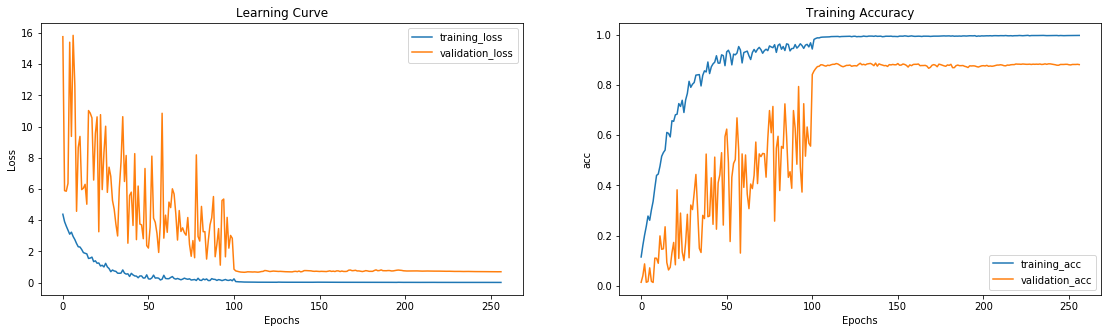

In [23]:
plt.figure(figsize=(19, 5))

training_loss = fitting_result.history['loss']
val_loss = fitting_result.history['val_loss']
plt.subplot(1,2,1)
plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')

training_acc = fitting_result.history['acc']
val_acc = fitting_result.history['val_acc']
plt.subplot(1,2,2)
plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.title("Training Accuracy")
plt.legend(loc='best')

plt.show()

In [18]:
# convert the output (probabilistics) to classes
def proba_to_class(a):
    classCount = len(a[0])
    print('proba_to_class:classCount={}'.format(classCount)) #M:
    to_return = np.empty((0,classCount))
    for row in a:
        maxind = np.argmax(row)
        to_return = np.vstack((to_return, [1 if i == maxind else 0 for i in range(classCount)]))
    return to_return

In [19]:
# calculate metrics on test data with the last model 
from sklearn.metrics import average_precision_score, accuracy_score
y_result = model.predict(X_test)
y_argmax = np.argmax(y_result, axis=1)
y_argmax

array([20, 69, 39, ..., 24, 39, 13])

In [20]:
y_real = np.argmax(y_test, axis=1)
y_real

array([20, 69, 39, ..., 24, 39, 13])

In [21]:
# calculate metrics on test data with the last model 
from sklearn.metrics import average_precision_score, accuracy_score

map = average_precision_score(y_test, y_result, average='micro')
print("AveragePrecision: {}".format(map))

accuracy = accuracy_score(y_test, proba_to_class(y_result))
print("Accuracy: {}".format(accuracy))

AveragePrecision: 0.9386581899571382
proba_to_class:classCount=123
Accuracy: 0.8880393227744402


In [ ]:
# # reload the best model with smallest validation loss and calculate metrics on test data
# print("----- Loading best model from: {}  -------".format(bestModelFilePath_val_loss))
# model.load_weights(bestModelFilePath_val_loss)
# y_result_bm = model.predict(X_test)
# map_bm_val_loss = average_precision_score( y_test.data[y_test.start: y_test.end], y_result_bm, average='macro')
# accuracy_bm_val_loss = accuracy_score(y_test.data[y_test.start: y_test.end], proba_to_class(y_result_bm))
# print("AveragePrecision: {}".format(map_bm_val_loss))
# print("Accuracy: {}".format(accuracy_bm_val_loss))

In [ ]:
# # reload the best model with highest validation accuracy and calculate metrics on test data
# print("----- Loading best model from: {}  -------".format(bestModelFilePath_val_acc))
# model.load_weights(bestModelFilePath_val_acc)
# y_result_bm = model.predict(X_test)
# map_bm_val_acc = average_precision_score( y_test.data[y_test.start: y_test.end], y_result_bm, average='macro')
# accuracy_bm_val_acc = accuracy_score(y_test.data[y_test.start: y_test.end], proba_to_class(y_result_bm))
# print("AveragePrecision: {}".format(map_bm_val_acc))
# print("Accuracy: {}".format(accuracy_bm_val_acc))

In [ ]:
# # save the results summery into an excel file
# import log
# log.logToXLS(logfileName, model, fitting_result, {'execution(s)':elapsed, 'map':map, 'accuracy':accuracy, 'map_bm_val_loss':map_bm_val_loss, 'accuracy_bm_val_loss':accuracy_bm_val_loss,'map_bm_val_acc':map_bm_val_acc, 'accuracy_bm_val_acc':accuracy_bm_val_acc, 'modelPyFile': modelPath})